In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EP_temporal_analysis'

#### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [7]:
print('Number of Templeton experiments: {:d}'.format(len(metadata)))
print('Number of mice: {:d}'.format(len(np.unique(metadata['mouse_name'].values))))

Number of Templeton experiments: 96
Number of mice: 39


In [8]:
n_mean = 20
comp_dict = {'early': [0.003, 0.05], 'late': [0.15, 0.25]}
mm_pix = 0.025

In [9]:
all_mice = np.unique(metadata['mouse_name'].values)

all_exp_metrics = []
day1_day2 = []
EP_traces = {}
for mousei in all_mice:
    
    mousemeta = metadata[metadata['mouse_name'].str.contains(mousei)]
    if len(mousemeta) < 2: # need at least 2 days recording
        continue
    
    # get days with estim #
    estim_day = np.array([True if 'electrical' in x else False for x in mousemeta['stimulation'].values])
    # get days without urethane #
    non_urethane = np.array([True if 'urethane' not in x else False for x in mousemeta['drug'].values])
    # get days with good EEG #
    EEG_good = np.array([True if 'all' not in x else False for x in mousemeta['EEG bad_channels'].values])
    valid = estim_day * non_urethane * EEG_good
#     print('{}: {:d} days'.format(mousei, np.sum(valid)))
    if np.sum(valid) < 2: # need 2 days of estim, non-urethane, with EEG
        continue
        
    EP_traces[mousei] = {}
    EPamp_days = []
    tip_coords_days = []
    for indi, exprow in mousemeta[valid][:2].iterrows():
        data_loc = os.path.join('F:\psi_exp', mousei, exprow['exp_name'], 'experiment1', 'recording1')
        if not os.path.exists(data_loc):
            continue
        
        exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
        exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
        print('{} - {}'.format(exp.mouse, exp_tag))
        
        ## stim electrode location ##
        stimloc_file = os.path.join(data_loc, 'stim_elec_location.json')
        with open(stimloc_file) as data_file:
            stimloc_data = json.load(data_file)
        tip_area = stimloc_data['tip']['area']
        tip_coords = np.array(stimloc_data['tip']['ccf_coords'])
        tip_coords_days.append(tip_coords)
        
        ## EEG EP amplitude ##
        badchstr = exprow['EEG bad_channels'].replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        
        all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        good_chs = np.array([x for x in eeg_chs if x not in bad_chs])

        stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
        currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
        if len(currents) > 1:
            estim_current = str(currents[1])
        else:
            estim_current = str(currents[0])
        
        event_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': estim_current, 'sweep': 0}, out='index')
        event_traces = all_EEG_traces[:, :, event_inds]
        event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
        resting_trials = stim_log['resting_trial'].values[event_inds]
        
        ## Average across every n_mean trials ##
        if event_traces.shape[2] % n_mean == 0:
            n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
            n_rest_trials = np.sum(resting_trials.reshape((-1, n_mean)), axis=-1)
        else:
            print('Number of trials is not divisible by n_mean.')
        ## Then find mean across chs of the absolute value of trial averages ##
        rect_mean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)
        EP_traces[mousei][exp_tag] = [EEG_event_timestamps, rect_mean, tip_area]

        ## ADD exp info to list for df ##
        exp_temp_data = [mousei, exp_tag, tip_area, tip_coords, n_rest_trials[0], n_rest_trials[-1]]

        ## Get rectified mean amplitude within test windows ##
        amptemp = []
        for wini, windowi in comp_dict.items():
            testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
            mean_amp = np.mean(rect_mean[testinds, :], axis=0)
            exp_temp_data.extend([mean_amp[0], mean_amp[-1]])
            amptemp.append(mean_amp[0])
        EPamp_days.append(amptemp)
        all_exp_metrics.append(exp_temp_data)
        del exp_temp_data
    
    ## Now get day1-day2 metrics ##
    if len(tip_coords_days) == 0:
        continue
    day1_day2.append([
        mousei,
        np.linalg.norm(tip_coords_days[0] - tip_coords_days[1]) * mm_pix,
        EPamp_days[0][0] - EPamp_days[1][0],
        EPamp_days[0][1] - EPamp_days[1][1]]
    )
        
all_subexp_df = pd.DataFrame(
    all_exp_metrics, columns=[
        'subject', 'experiment', 'stim_area', 'stim_coords', 'first_rest', 'last_rest',
        'first_early_amp', 'last_early_amp', 'first_late_amp', 'last_late_amp'
    ])
all_sub_d1d2 = pd.DataFrame(day1_day2, columns=['subject', 'stim_dist', 'delta_early', 'delta_late'])

Experiment type: electrical stimulation
666194 - pilot_aw
Experiment type: electrical stimulation
666194 - pilot_aw_psi
Experiment type: electrical stimulation
669117 - pilot_aw
Experiment type: electrical stimulation
669117 - pilot_aw_psi
Experiment type: electrical stimulation
669118 - pilot_aw
Experiment type: electrical stimulation
669118 - pilot_aw_psi
Experiment type: electrical stimulation
673449 - aw_psi
Experiment type: electrical stimulation
673449 - aw_psi_d2
Experiment type: electrical and sensory stimulation
676726 - aw_psi
Experiment type: electrical and sensory stimulation
676726 - aw_iso
Experiment type: electrical and sensory stimulation
676727 - aw_psi
Experiment type: electrical and sensory stimulation
676727 - aw_iso
Experiment type: electrical stimulation
689240 - aw_psi
Experiment type: electrical and sensory stimulation
689240 - aw_iso
Experiment type: electrical and sensory stimulation
689242 - aw_psi
Experiment type: electrical and sensory stimulation
689242 - 

In [10]:
all_subexp_df.head()

,subject,experiment,stim_area,stim_coords,first_rest,last_rest,first_early_amp,last_early_amp,first_late_amp,last_late_amp
0,mouse666194,pilot_aw,ORBm6a,"[121, 120, 192]",7,0,44.642763,34.624783,41.109189,16.605304
1,mouse666194,pilot_aw_psi,ORBm6a,"[124, 120, 189]",13,16,44.416655,27.446176,56.788042,28.682045
2,mouse669117,pilot_aw,MOs6a,"[126, 106, 177]",7,14,49.033320,47.084391,22.128294,24.820409
3,mouse669117,pilot_aw_psi,MOs6a,"[125, 106, 181]",16,18,25.379748,21.473832,6.692932,8.527869
4,mouse669118,pilot_aw,MOs6a,"[123, 106, 183]",9,8,27.830808,19.647802,20.658659,9.822189


In [12]:
print(len(all_sub_d1d2))

19


In [11]:
all_sub_d1d2.head()

,subject,stim_dist,delta_early,delta_late
0,mouse666194,0.106066,0.226108,-15.678853
1,mouse669117,0.103078,23.653573,15.435362
2,mouse669118,0.480885,-0.886563,3.343459
3,mouse673449,0.709313,-23.320376,-29.976513
4,mouse676726,0.561249,-3.096634,8.107492


### Plot some EPs

<IPython.core.display.Javascript object>


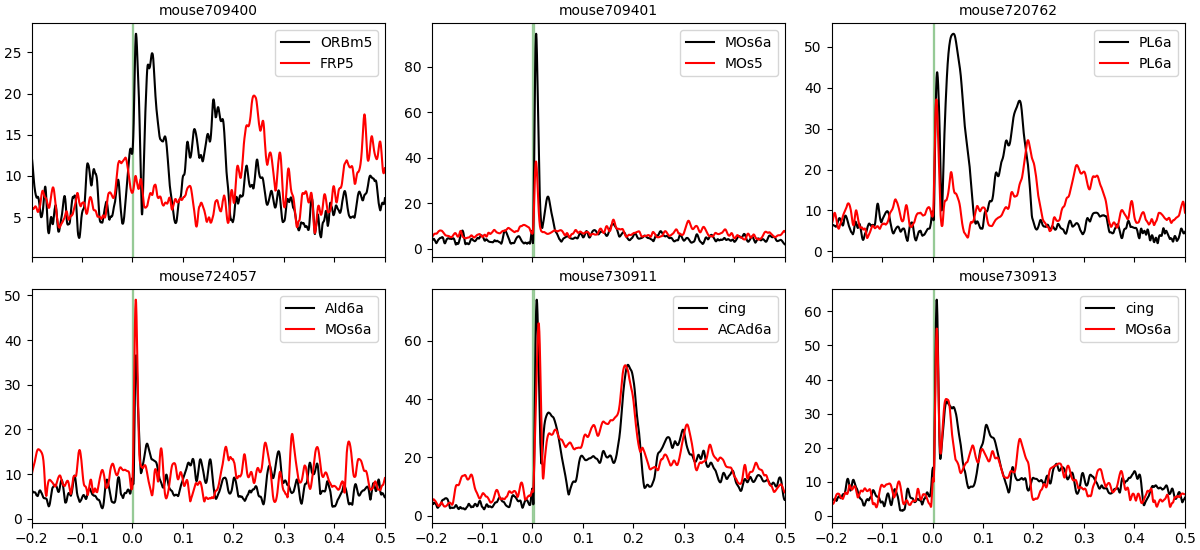

In [25]:
nmice = 6
pwin = [-0.2, 0.5]

fig, axs = plt.subplots(2, int(nmice / 2), figsize=(12, 5.5), constrained_layout=True, sharex=True)

for ax, mousei in zip(axs.flatten(), list(EP_traces.keys())[:nmice]):
    ax.set_title(mousei)
    ax.axvspan(0, 0.002, color='g', alpha=0.3)
    for pcol, (expi, datai) in zip(['k', 'r'], EP_traces[mousei].items()):
        ax.plot(datai[0], datai[1][:,0], color=pcol, label=datai[2])
    ax.set_xlim(pwin)
    ax.legend()
    
## Save ##
figname = 'd1d2EPexamples1.png'
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [22]:
all_subexp_df[all_subexp_df['subject'] == 'mouse673449'].head()

,subject,experiment,stim_area,stim_coords,first_rest,last_rest,first_early_amp,last_early_amp,first_late_amp,last_late_amp
6,mouse673449,aw_psi,ORBm5,"[112, 126, 199]",0,6,25.178122,22.964141,7.840731,11.001291
7,mouse673449,aw_psi_d2,MOs6a,"[121, 106, 181]",11,17,48.498498,23.348645,37.817244,7.711159


## Change in EP amplitude from day 1 to day 2

<IPython.core.display.Javascript object>


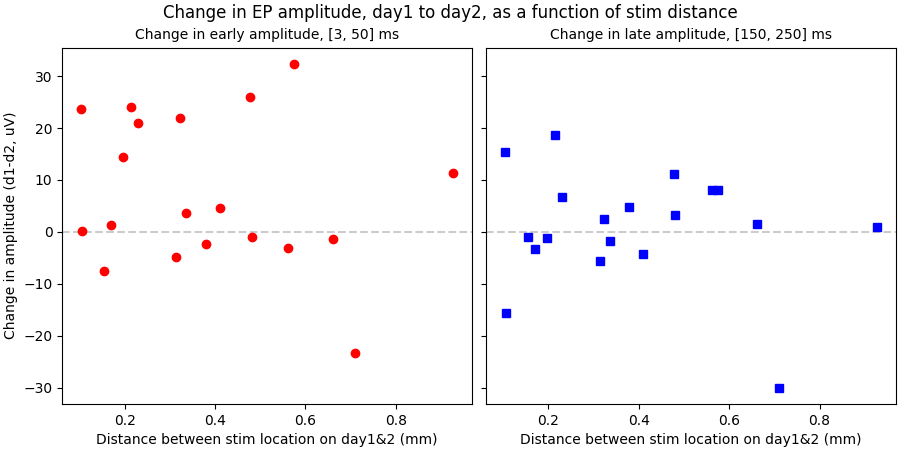

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5), constrained_layout=True, sharex=True, sharey=True)

axs[0].axhline(0, color='k', linestyle='dashed', alpha=0.2)
axs[0].plot(all_sub_d1d2['stim_dist'], all_sub_d1d2['delta_early'], 'ro')
axs[0].set_title('Change in early amplitude, [3, 50] ms')
axs[0].set_xlabel('Distance between stim location on day1&2 (mm)')
axs[0].set_ylabel('Change in amplitude (d1-d2, uV)')

axs[1].axhline(0, color='k', linestyle='dashed', alpha=0.2)
axs[1].plot(all_sub_d1d2['stim_dist'], all_sub_d1d2['delta_late'], 'bs')
axs[1].set_title('Change in late amplitude, [150, 250] ms')
axs[1].set_xlabel('Distance between stim location on day1&2 (mm)')

fig.suptitle('Change in EP amplitude, day1 to day2, as a function of stim distance')

## Save ##
figname = 'deltaamp_stimdist.png'
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

## EP amplitude based on stim area

In [13]:
np.unique(all_subexp_df['stim_area'].values)

array(['ACAd6a', 'AId6a', 'FRP5', 'MOp5', 'MOp6a', 'MOs5', 'MOs6a',
       'ORBl5', 'ORBm5', 'ORBm6a', 'PL6a', 'cing', 'scwm'], dtype=object)

In [14]:
# region_dict = {
#     'ACA': ['ACAd6a'],
#     'FRP': ['FRP5'],
#     'MOp': ['MOp5', 'MOp6a'],
#     'MOs': ['MOs5', 'MOs6a'],
#     'ORB': ['ORBl5', 'ORBm5', 'ORBm6a'],
#     'PL': ['PL6a'],
#     'fibers': ['scwm']
# }
region_dict = {
    'ACAd6a': 'ACA', 'PL6a': 'PL', 'FRP5': 'FRP', 'ORBl5': 'ORB', 'ORBm5': 'ORB', 'ORBm6a': 'ORB', 'scwm': 'fibers',
    'MOp5': 'MOp', 'MOp6a': 'MOp', 'MOs5': 'MOs', 'MOs6a': 'MOs', 'AId6a': 'ORB', 'cing': 'fibers'
}

In [15]:
all_subexp_df['MOs_stim'] = [True if 'MOs' in x else False for x in all_subexp_df['stim_area'].values]
all_subexp_df['region'] = [region_dict[x] for x in all_subexp_df['stim_area'].values]
all_subexp_df.head()

,subject,experiment,stim_area,stim_coords,first_rest,last_rest,first_early_amp,last_early_amp,first_late_amp,last_late_amp,MOs_stim,region
0,mouse666194,pilot_aw,ORBm6a,"[121, 120, 192]",7,0,44.642763,34.624783,41.109189,16.605304,False,ORB
1,mouse666194,pilot_aw_psi,ORBm6a,"[124, 120, 189]",13,16,44.416655,27.446176,56.788042,28.682045,False,ORB
2,mouse669117,pilot_aw,MOs6a,"[126, 106, 177]",7,14,49.033320,47.084391,22.128294,24.820409,True,MOs
3,mouse669117,pilot_aw_psi,MOs6a,"[125, 106, 181]",16,18,25.379748,21.473832,6.692932,8.527869,True,MOs
4,mouse669118,pilot_aw,MOs6a,"[123, 106, 183]",9,8,27.830808,19.647802,20.658659,9.822189,True,MOs


<IPython.core.display.Javascript object>


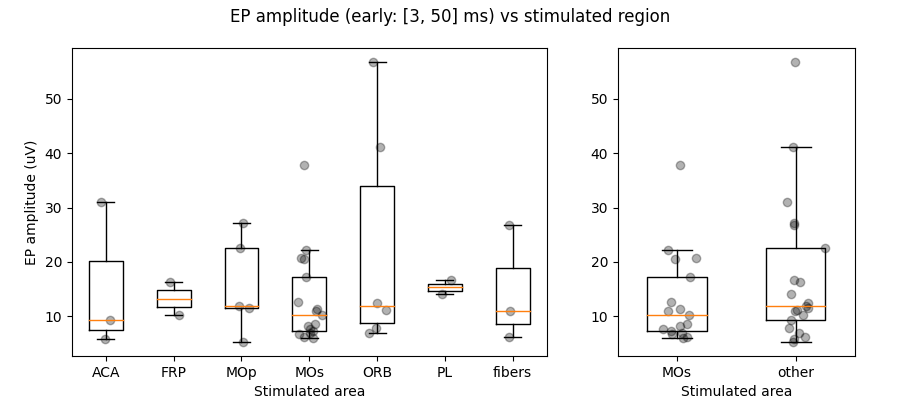

In [17]:
plotvals = 'first_late_amp'

fig  = plt.figure(figsize=(9,4))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1], left=0.08, right=0.95)
axreg = fig.add_subplot(gs[0])
axMO = fig.add_subplot(gs[1], sharey=axreg)


reglabels = []
for ii, regi in enumerate(np.unique(all_subexp_df['region'].values)):
    yvals = all_subexp_df[all_subexp_df['region'] == regi][plotvals].values
    xs = np.random.normal(ii, 0.08, len(yvals))
    axreg.boxplot(yvals, positions=[ii], widths=[0.5], showfliers=False)
    axreg.scatter(xs, yvals, c='k', marker='o', alpha=0.3)
    reglabels.append(regi)

axreg.set_ylabel('EP amplitude (uV)')
axreg.set_xlabel('Stimulated area')
axreg.set_xticklabels(reglabels)

for ii, MOsTF in enumerate([True, False]):
    yvals = all_subexp_df[all_subexp_df['MOs_stim'] == MOsTF][plotvals].values
    xs = np.random.normal(ii, 0.08, len(yvals))
    axMO.boxplot(yvals, positions=[ii], widths=[0.5], showfliers=False)
    axMO.scatter(xs, yvals, c='k', marker='o', alpha=0.3)

axMO.set_xlabel('Stimulated area')
axMO.set_xticks([0,1])
axMO.set_xticklabels(['MOs', 'other'])

fig.suptitle('EP amplitude (early: [3, 50] ms) vs stimulated region')

## Save ##
figname = 'EPamp_stimloc_{}.png'.format(plotvals)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Early amplitude vs late amplitude

<IPython.core.display.Javascript object>


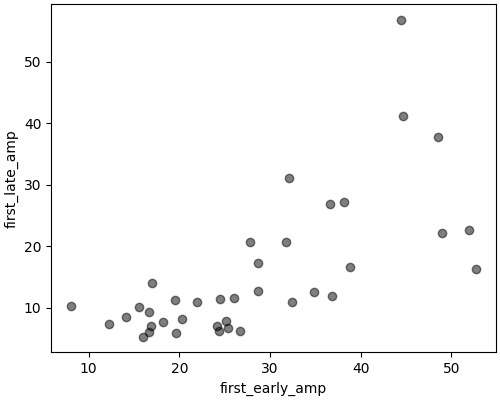

Text(0, 0.5, 'first_late_amp')

In [18]:
valx = 'first_early_amp'
valy = 'first_late_amp'

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(all_subexp_df[valx].values, all_subexp_df[valy].values, c='k', marker='o', alpha=0.5)
ax.set_xlabel(valx)
ax.set_ylabel(valy)

## Save ##
# figname = 'EPamp_stimloc_{}.png'.format(plotvals)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

In [87]:
all_subexp_df[all_subexp_df['subject'] == 'mouse703065']

,subject,experiment,stim_area,stim_coords,first_rest,last_rest,first_early_amp,last_early_amp,first_late_amp,last_late_amp,MOs_stim,MO_stim,region
22,mouse703065,aw_psi,ACAd6a,"[168, 102, 187]",0,0,19.635726,19.681933,5.853935,5.947164,False,False,ACA
23,mouse703065,aw_iso,MOs6a,"[167, 96, 176]",7,13,24.440393,24.269253,11.373510,15.332987,True,True,MOs


Test with 1 subject

In [10]:
all_mice = np.unique(metadata['mouse_name'].values)
all_mice

array(['mouse631037', 'mouse654182', 'mouse655955', 'mouse655956',
       'mouse657903', 'mouse666193', 'mouse666194', 'mouse666196',
       'mouse669117', 'mouse669118', 'mouse673449', 'mouse676726',
       'mouse676727', 'mouse678912', 'mouse678913', 'mouse688277',
       'mouse689239', 'mouse689240', 'mouse689241', 'mouse689242',
       'mouse692643', 'mouse692644', 'mouse703062', 'mouse703063',
       'mouse703064', 'mouse703065', 'mouse709399', 'mouse709400',
       'mouse709401', 'mouse709402', 'mouse720762', 'mouse724057',
       'mouse728449', 'mouse730911', 'mouse730913', 'mouse735049',
       'mouse735050', 'mouse735051', 'mouse735052'], dtype=object)

In [24]:
all_exp_metrics = []
day1_day2 = []

mousei = all_mice[8]
mousemeta = metadata[metadata['mouse_name'].str.contains(mousei)]

estim_day = np.array([True if 'electrical' in x else False for x in mousemeta['stimulation'].values])
non_urethane = np.array([True if 'urethane' not in x else False for x in mousemeta['drug'].values])
EEG_good = np.array([True if 'all' not in x else False for x in mousemeta['EEG bad_channels'].values])
valid = estim_day * non_urethane * EEG_good



EPamp_days = []
tip_coords_days = []
for indi, exprow in mousemeta[valid][:2].iterrows():
    data_loc = os.path.join('F:\psi_exp', mousei, exprow['exp_name'], 'experiment1', 'recording1')
    if not os.path.exists(data_loc):
        continue

    exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    print('{} - {}'.format(exp.mouse, exp_tag))

    ## stim electrode location ##
    stimloc_file = os.path.join(data_loc, 'stim_elec_location.json')
    with open(stimloc_file) as data_file:
        stimloc_data = json.load(data_file)
    tip_area = stimloc_data['tip']['area']
    tip_coords = np.array(stimloc_data['tip']['ccf_coords'])
    tip_coords_days.append(tip_coords)

    ## EEG EP amplitude ##
    badchstr = exprow['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))

    all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    good_chs = np.array([x for x in eeg_chs if x not in bad_chs])

    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        estim_current = str(currents[1])
    else:
        estim_current = str(currents[0])

    event_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': estim_current, 'sweep': 0}, out='index')
    event_traces = all_EEG_traces[:, :, event_inds]
    event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
    resting_trials = stim_log['resting_trial'].values[event_inds]

    ## Average across every n_mean trials ##
    if event_traces.shape[2] % n_mean == 0:
        n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
        n_rest_trials = np.sum(resting_trials.reshape((-1, n_mean)), axis=-1)
    else:
        print('Number of trials is not divisible by n_mean.')
    ## Then find mean across chs of the absolute value of trial averages ##
    rect_mean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)

    ## ADD exp info to list for df ##
    exp_temp_data = [mousei, exp_tag, tip_area, tip_coords, n_rest_trials[0], n_rest_trials[-1]]

    ## Get rectified mean amplitude within test windows ##
    amptemp = []
    for wini, windowi in comp_dict.items():
        testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
        mean_amp = np.mean(rect_mean[testinds, :], axis=0)
        exp_temp_data.extend([mean_amp[0], mean_amp[-1]])
        amptemp.append(mean_amp[0])
    EPamp_days.append(amptemp)
    all_exp_metrics.append(exp_temp_data)
    del exp_temp_data

## Now get day1-day2 metrics ##

tip_dist = np.linalg.norm(tip_coords_days[0] - tip_coords_days[1])
delta_early_amp = EPamp_days[0][0] - EPamp_days[1][0]
delta_late_amp = EPamp_days[0][1] - EPamp_days[1][1]

Experiment type: electrical stimulation
669117 - pilot_aw
Experiment type: electrical stimulation
669117 - pilot_aw_psi


In [25]:
tip_coords_days

[array([126, 106, 177]), array([125, 106, 181])]

In [26]:
tip_dist = np.linalg.norm(tip_coords_days[0] - tip_coords_days[1])

In [ ]:
delta_early_amp = EPamp_days[0][0] - EPamp_days[1][0]
delta_late_amp = EPamp_days[0][1] - EPamp_days[1][1]

In [29]:
EPamp_days[0][0]

49.033320158687694

In [28]:
EPamp_days[1]

[25.379747617136545, 6.6929317692792525]

### Loop through mice with estim days

In [32]:
for mousei in mice_2days_estim:
    print(mousei)
    mousemeta = metadata[metadata['mouse_name'].str.contains(mousei)]

mouse666194
mouse669117
mouse669118
mouse673449
mouse676726
mouse676727
mouse689240
mouse689242
mouse692644
mouse703063
mouse703064
mouse703065
mouse709400
mouse709401
mouse720762
mouse724057
mouse730911
mouse730913
mouse735049


In [35]:
thispath = os.path.join('F:\psi_exp', mousei, mousemeta['exp_name'].values[0], 'experiment1', 'recording1')
print(thispath)

F:\psi_exp\mouse735049\aw_sal_2024-05-22_11-05-25\experiment1\recording1


### Load subject

In [7]:
# data_loc = r"F:\psi_exp\mouse666194\pilot_aw_2023-02-22_12-32-58\experiment1\recording1" # DAY1
data_loc = r"F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23_10-40-34\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-14-39\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24_09-55-33\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-09-15\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_psi_2023-03-30_11-37-07\experiment1\recording1" # DAY2

In [8]:
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

Experiment type: electrical stimulation
666194 - pilot_aw_psi


In [9]:
## Grab exp metadata from Templeton-log_exp ##
exp_meta = metadata[(
    (metadata['mouse_name'].str.contains(exp.mouse)) &
    (metadata['exp_name'].str.contains(data_loc[data_loc.find('mouse')+12:data_loc.find('experiment1')-4]))
)].squeeze()
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)
## Get injection times ##
inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
print(inj_times)

[]
[197.21, 763.06]


Re-check trial signal quality

Load stim log

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,40,0.0004,1061.14291,1061.14331,0,True,0.000000,True
1,biphasic,40,0.0004,1064.75000,1064.75040,0,True,0.075932,False
2,biphasic,40,0.0004,1069.21232,1069.21272,0,True,0.113898,False
3,biphasic,40,0.0004,1072.71738,1072.71778,0,True,0.000000,True
4,biphasic,40,0.0004,1076.99273,1076.99313,0,True,7.441341,False


Load EEG all event traces

In [11]:
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
good_chs = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(good_chs))

30


Load and plot running and pupil

In [12]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [13]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

    ## Smooth eye diameter ##
    smooth_eyeD = np.zeros_like(eyeD)
    k = 50 # filter window is actually k*2+1
    for i in range(k, len(eyeD)-k-1):
        smooth_eyeD[i] = np.mean(eyeD[i-k:i+k]) # each point is the average of k surrounding points
    smooth_eyeD[:k] = eyeD[:k]
    smooth_eyeD[-k-1:] = eyeD[-k-1:]

    normpupil = pupilD / smooth_eyeD
else:
    print('No local Pupileye*.csv file. Check server.')
    normpupil = None

<IPython.core.display.Javascript object>


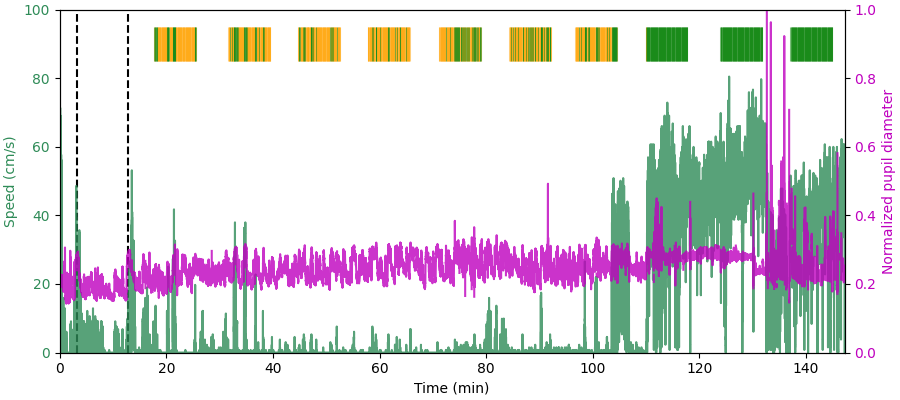

In [14]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='k', linestyle='dashed')

ax.plot(speedts/60, speed, 'seagreen', alpha=0.8)
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')
ax.set_ylim([0, 100])

ax2 = ax.twinx()
if normpupil is not None:
    ax2.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    ax2.set_ylabel('Normalized pupil diameter', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
ax2.set_ylim([0, 1])

## add stim times to plot ##
# for etype, ecol in zip(['biphasic', 'circle'], ['orange', 'blue']):
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    ax2.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)

## Investigate EPs

In [15]:
stim_log.tail()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
1195,biphasic,40,0.0004,8682.95676,8682.95716,9,True,21.048364,False
1196,biphasic,40,0.0004,8686.57460,8686.57500,9,True,40.479375,False
1197,biphasic,40,0.0004,8690.37170,8690.37210,9,True,43.592589,False
1198,biphasic,40,0.0004,8694.19090,8694.19130,9,True,40.122495,False
1199,biphasic,40,0.0004,8698.11549,8698.11589,9,True,35.513419,False


In [16]:
print('{:d} good trials out of {:d} total'.format(np.sum(stim_log.good.values), len(stim_log)))
print('{:d} resting trials out of {:d} total'.format(np.sum(stim_log.resting_trial.values), len(stim_log)))

1198 good trials out of 1200 total
659 resting trials out of 1200 total


In [17]:
evtype = 'biphasic'
evpar = '50'

event_inds = get_events_wdict(stim_log, {'stim_type': evtype, 'parameter': evpar}, out='index')
event_traces = all_EEG_traces[:, :, event_inds]
## Apply common average reference ##
event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]

resting_trials = stim_log['resting_trial'].values[event_inds]

In [18]:
event_traces.shape

(10000, 30, 0)

Global field power across chs

Rectified amplitude - a la Simone

Should we do [mean(trials) -> abs(values) -> mean(chs)] or [abs(values) -> mean(trials) -> mean(chs)]?
<br>**mean(trials) -> abs(values) -> mean(chs)**
<br>Then Simone takes the average value within the component window (can take the max also, will see the same trend).

<IPython.core.display.Javascript object>


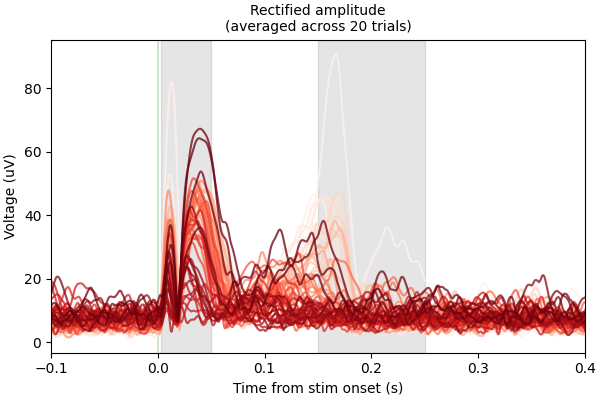

Text(0.5, 1.0, 'Rectified amplitude\n(averaged across 20 trials)')

In [19]:
# mean(trials) -> abs(values) -> mean(chs) #
n_mean = 20
pwin = [-0.1, 0.4] # [-2.0, 2.0]

## Average across every n_mean trials ##
if event_traces.shape[2] % n_mean == 0:
    n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
else:
    print('Number of trials is not divisible by n_mean.')
meanmean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)

colors = plt.cm.Reds(np.linspace(0, 1, int(event_traces.shape[2]/n_mean)+1))
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.2)

## Add Simone's windows ##
ax.axvspan(0.003, 0.05, color='k', alpha=0.1)
ax.axvspan(0.15, 0.25, color='k', alpha=0.1)

for ii in range(meanmean.shape[1]):
    ax.plot(EEG_event_timestamps, meanmean[:,ii], color=colors[ii+1], alpha=0.75)

ax.set_xlim(pwin)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Rectified amplitude\n(averaged across {:d} trials)'.format(n_mean))

<IPython.core.display.Javascript object>


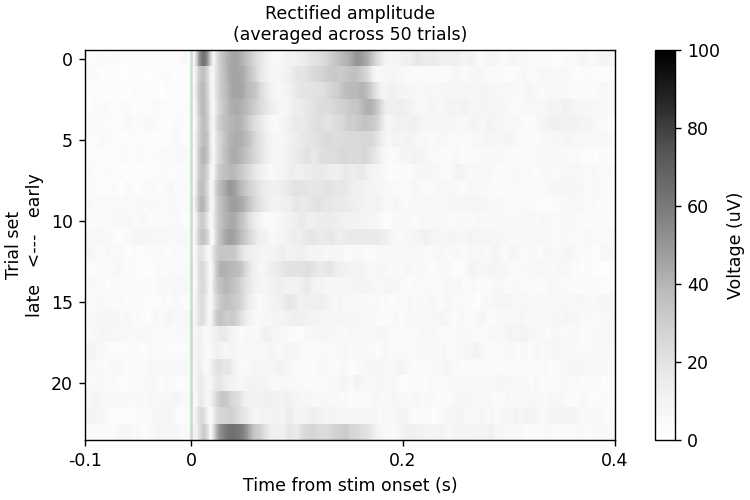

In [23]:
pwin = [-0.1, 0.4]

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
pwinind = [find_nearest_ind(EEG_event_timestamps, x) for x in pwin]

ax.axvline(find_nearest_ind(EEG_event_timestamps, 0), color='g', alpha=0.2)

## Add Simone's windows ##
# ax.axvspan(0.003, 0.05, color='k', alpha=0.1)
# ax.axvspan(0.15, 0.25, color='k', alpha=0.1)

vim = ax.imshow(meanmean.T, cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=100)

ax.set_xlim(pwinind)
# ax.set_xticklabels([EEG_event_timestamps[int(x)] for x in ax.get_xticks()])
# Set new ticks #
new_ticks = [pwin[0], 0, np.mean([0, pwin[1]]), pwin[1]]
ax.set_xticks([find_nearest_ind(EEG_event_timestamps, x) for x in new_ticks])
ax.set_xticklabels(new_ticks)

ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Trial set\nlate   <---   early')
ax.set_title('Rectified amplitude\n(averaged across {:d} trials)'.format(n_mean))
cb = fig.colorbar(vim, label='Voltage (uV)')

## EEG metrics for trial sets

In [45]:
n_mean = 20

comp_dict = {'early': [0.003, 0.05], 'mid': [0.08, 0.2], 'late': [0.15, 0.25], 'baseline': [-0.2, -0.1]}
compinfo = {'early': ['r', 'o'], 'mid': ['g', 's'], 'late': ['b', 'v'], 'baseline': ['gray', '<']}

# comp_dict = {'early': [0.003, 0.02], 'earlySR': [0.003, 0.05], 'mid': [0.08, 0.2], 'lateSR': [0.15, 0.25]}
# compinfo = {'early': ['darkviolet', 'P'], 'earlySR': ['r', 'o'], 'mid': ['g', 's'], 'lateSR': ['b', 'v']}

In [42]:
# mean(trials) -> abs(values) -> mean(chs) #
## Average across every n_mean trials ##
if event_traces.shape[2] % n_mean == 0:
    num_trial_sets = int(event_traces.shape[2] / n_mean)
    n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
    n_rest_trials = np.sum(resting_trials.reshape((-1, n_mean)), axis=-1)
else:
    print('Number of trials is not divisible by n_mean.')
## Then find mean across chs of the absolute value of trial averages ##
rect_mean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)

## Calculate PCI here?? Probably don't need this metric. ##

EP_metrics = {}
EP_metrics['n_rest_trials'] = n_rest_trials
EP_metrics['n_run_trials'] = n_mean - n_rest_trials
## Get rectified mean amplitude within test windows ##
for wini, windowi in comp_dict.items():
    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
    mean_amp = np.mean(rect_mean[testinds, :], axis=0)
    EP_metrics[wini + '_mean_amp'] = mean_amp
    
EP_metrics_df = pd.DataFrame(EP_metrics)
EP_metrics_df.head()

,n_rest_trials,n_run_trials,early_mean_amp,mid_mean_amp,late_mean_amp,baseline_mean_amp
0,16,4,25.379748,10.829288,6.692932,7.898512
1,13,7,21.866353,7.765353,7.557536,6.481495
2,19,1,21.954082,16.286586,14.357243,10.324510
3,16,4,27.631364,11.353896,10.725584,5.638060
4,20,0,22.093932,12.338709,9.366228,5.173822


### Make combo summary plot

In [28]:
pwin = [-0.1, 0.4]

<IPython.core.display.Javascript object>


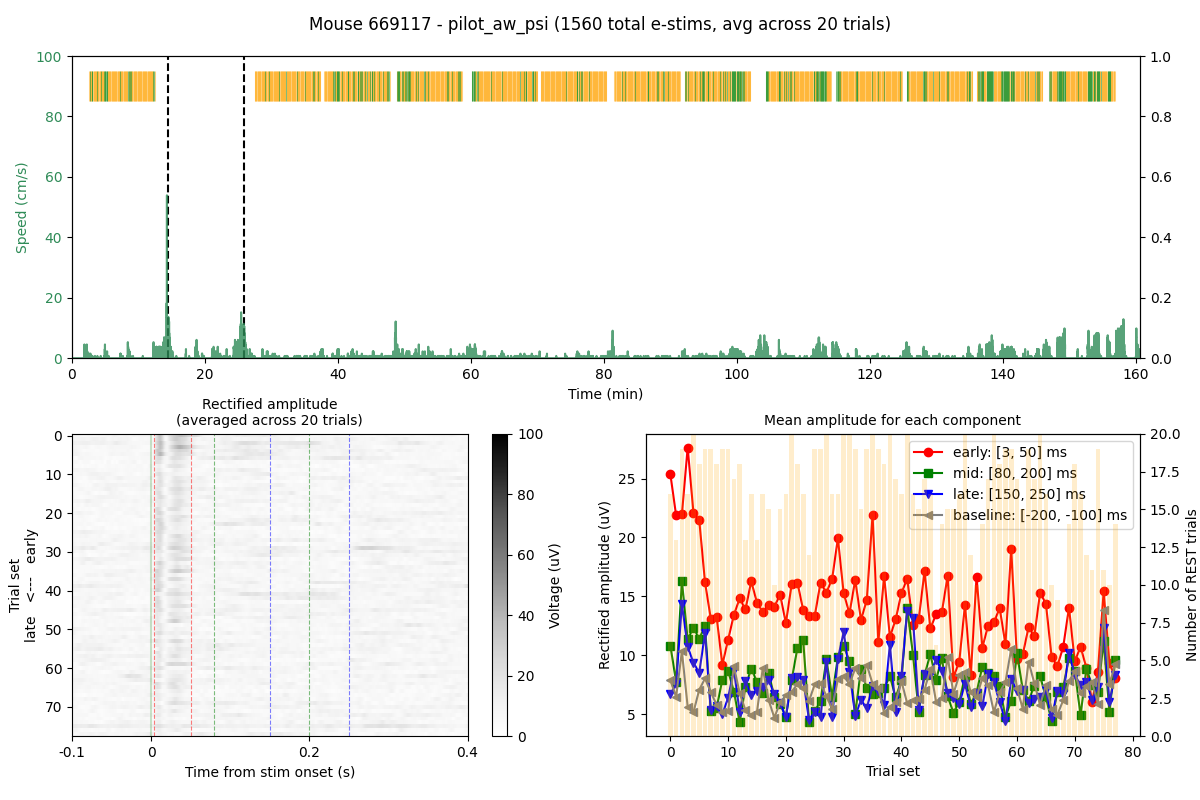

In [47]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.06, right=0.95, top=0.93, bottom=0.08, hspace=0.25, wspace=0.16)

axsp = fig.add_subplot(gs[0,:])
axim = fig.add_subplot(gs[1,0])
axamp = fig.add_subplot(gs[1,1])

## Plot speed, pupil, and estim times ##
if inj_times is not None:
    for itime in inj_times:
        axsp.axvline(itime/60, color='k', linestyle='dashed')

axsp.plot(speedts/60, speed, 'seagreen', alpha=0.8)
axsp.set_xlim([speedts[0]/60, speedts[-1]/60])
axsp.set_xlabel('Time (min)')
axsp.set_ylabel('Speed (cm/s)', color='seagreen')
axsp.tick_params(axis='y', labelcolor='seagreen')
axsp.set_ylim([0, 100])
        
axpup = axsp.twinx()
if normpupil is not None:
    axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    axpup.set_ylabel('Normalized pupil diameter', color='m')
    axpup.tick_params(axis='y', labelcolor='m')
axpup.set_ylim([0, 1])

for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)
    
## Plot trial set rectified average EPs ##
pwinind = [find_nearest_ind(EEG_event_timestamps, x) for x in pwin]
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0), color='g', alpha=0.2)
vim = axim.imshow(rect_mean.T, cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=100)
## Add Simone's windows ##
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.003), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.05), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.08), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.2), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.15), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.25), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.set_xlim(pwinind)
new_ticks = [pwin[0], 0, np.mean([0, pwin[1]]), pwin[1]]
axim.set_xticks([find_nearest_ind(EEG_event_timestamps, x) for x in new_ticks])
axim.set_xticklabels(new_ticks)
axim.set_xlabel('Time from stim onset (s)')
axim.set_ylabel('Trial set\nlate   <---   early')
axim.set_title('Rectified amplitude\n(averaged across {:d} trials)'.format(n_mean))
cb = fig.colorbar(vim, label='Voltage (uV)', ax=axim)

## Plot EP component amplitudes ##
axbar = axamp.twinx()

axbar.bar(EP_metrics_df.index.values, EP_metrics_df['n_rest_trials'].values, color='orange', alpha=0.2)
axbar.set_ylim([0, n_mean])
for ii, (wini, windowi) in enumerate(comp_dict.items()):
    axamp.plot(
        EP_metrics_df[wini + '_mean_amp'].values, color=compinfo[wini][0], marker=compinfo[wini][1],
        label='{}: [{:d}, {:d}] ms'.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3))
    )

axamp.set_title('Mean amplitude for each component')#.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3)))
axamp.set_xlabel('Trial set')
axamp.set_ylabel('Rectified amplitude (uV)')
axamp.legend()
axbar.set_ylabel('Number of REST trials')

fig.suptitle('Mouse {} - {} ({:d} total e-stims, avg across {:d} trials)'.format(exp.mouse, exp_tag, len(event_inds), n_mean))

## Save ##
figname = '{}-{}_allEPsmetrics_{:d}avg.png'.format(exp.mouse, exp_tag, n_mean)
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Comparing individual trial sets

<IPython.core.display.Javascript object>


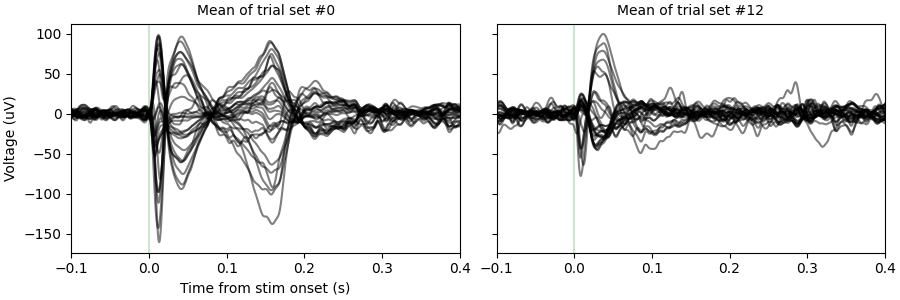

Text(0, 0.5, 'Voltage (uV)')

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True, sharex=True, sharey=True)

pptraces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
tset = [0, 12]

axs[0].axvline(0, color='g', alpha=0.2)
axs[0].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[0]], color='k', alpha=0.5)
axs[0].set_title('Mean of trial set #{:d}'.format(tset[0]))

axs[1].axvline(0, color='g', alpha=0.2)
axs[1].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[1]], color='k', alpha=0.5)
axs[1].set_title('Mean of trial set #{:d}'.format(tset[1]))


axs[0].set_xlim(pwin)
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Voltage (uV)')

<IPython.core.display.Javascript object>


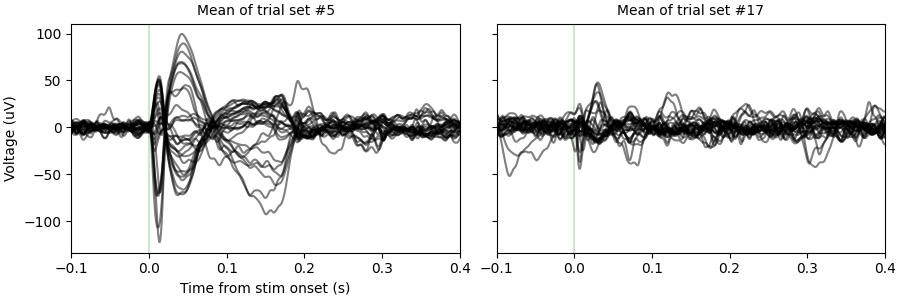

Text(0, 0.5, 'Voltage (uV)')

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True, sharex=True, sharey=True)

pptraces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
tset = [5, 17]

axs[0].axvline(0, color='g', alpha=0.2)
axs[0].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[0]], color='k', alpha=0.5)
axs[0].set_title('Mean of trial set #{:d}'.format(tset[0]))

axs[1].axvline(0, color='g', alpha=0.2)
axs[1].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[1]], color='k', alpha=0.5)
axs[1].set_title('Mean of trial set #{:d}'.format(tset[1]))


axs[0].set_xlim(pwin)
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Voltage (uV)')

<IPython.core.display.Javascript object>


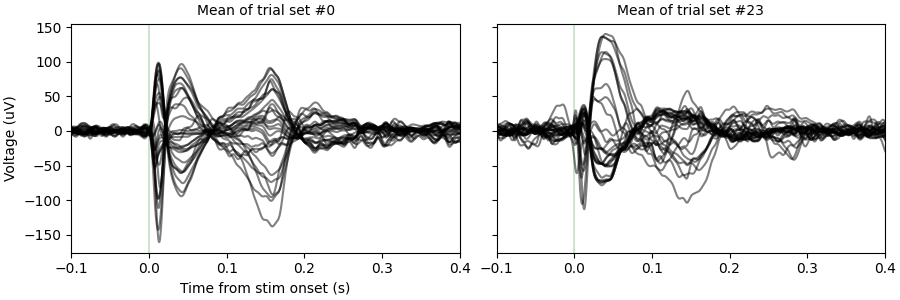

Text(0, 0.5, 'Voltage (uV)')

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True, sharex=True, sharey=True)

pptraces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
tset = [0, pptraces.shape[2]-1]

axs[0].axvline(0, color='g', alpha=0.2)
axs[0].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[0]], color='k', alpha=0.5)
axs[0].set_title('Mean of trial set #{:d}'.format(tset[0]))

axs[1].axvline(0, color='g', alpha=0.2)
axs[1].plot(EEG_event_timestamps, pptraces[:, good_chs, tset[1]], color='k', alpha=0.5)
axs[1].set_title('Mean of trial set #{:d}'.format(tset[1]))


axs[0].set_xlim(pwin)
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Voltage (uV)')